<a href="https://colab.research.google.com/github/tomiock/DL2024-25/blob/main/Problems%205%20-%20MLPs%20for%20Images/P5_MLP_for_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%204%20-%20MLP%20for%20Images/P4_MLP_for_Images.ipynb)

# MLP for image classification

In this notebook we are going to learn how to use a Multi-Layer Perceptron (MLP) (Fully-Connected, Feed-Forward Network) for classifying images.

An MLP like the ones you used in the notebook of last week can be used with any kind of input data if we can represent it as a vector of real numbers. The shape of the input vector determines the size of the first layer in the model.

In the case of images (2D arrays of pixel values) we can get fixed-length vectors by: (1) using always images of the same size, and (2) flatenning the images into a 1D array. The flatten operation collapses an array into one dimension. For example, if we have a grayscale image of $28\times28$ pixels, its flattened version is a 1d array of $784$ pixel values. Now we can fed these $784$ values into a MLP for classifiying the image.

### Import the necessary libraries

In [1]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Use GPU if available

In [2]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## The Fashion-MNIST dataset

[**Fashion-MNIST**](https://pytorch.org/vision/0.8/datasets.html#fashion-mnist) is a dataset consisting of a training set of $60,000$ examples and a test set of $10,000$ examples. Each example is a $28\times28$ grayscale image, associated with a label from $10$ classes. It was proposed as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each training and test example is assigned to one of the following labels: 0 T-shirt/top, 1 Trouser, 2 Pullover, 3 Dress, 4 Coat, 5 Sandal, 6 Shirt, 7 Sneaker, 8 Bag, 9 Ankle boot.

The Fashion-MNIST dataset is available in [torchvision](https://pytorch.org/vision/stable/index.html) and can be loaded with the following code:

In [3]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

print(train_set.data.size(), val_set.data.size())
print(train_set.targets.size(), val_set.targets.size())

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.4MB/s]

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


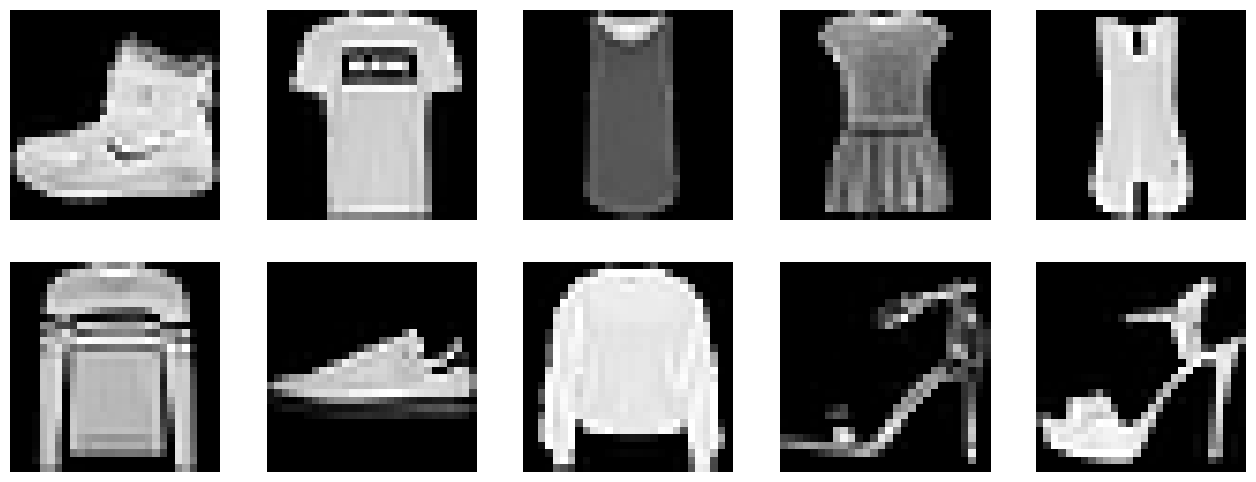

In [4]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = train_set.data[i,...]
    plt.imshow(image.squeeze().numpy(), cmap="gray")
    plt.axis('off');

<font color="blue">**Exercise 1**: When we loaded the Fashion-MNIST dataset we used the method `transforms.Compose`. Take a look at the documentation of [torchvision.transforms](https://pytorch.org/vision/0.8/transforms.html?highlight=transforms). Is there another transform that we can add to make our classification problem easier?</font>

---

First of all normalize the data if necessary. We can also expand the dataset doing data augmentation, for example mirroring the images, that way the shoes can points to both sides.

Most importantly, it can be used to have the images all the same size.

---

# Dataloaders

Now we introduce a **critical piece in any deep learning training process**: the dataloader. In Pytorch we can create a dataloader for a given dataset as follows:


In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False, num_workers=0)

<font color="blue">**Exercise 2**: Take a look at the documentation of [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) and answer the following questions:</font>

<font color="blue">- What are the benefits of a dataloader?</font>

<font color="blue">- How can we make the dataloaders defined above better?</font>

---

We can used to define the batch size. It is also parallelized by default, we can specify the number of cores that we have available, sometimes the loading of the data can be a bottleneck in the training.

For the above case, we can either increase the number of workers and the define properly the batch size.

---

<font color="blue">**Exercise 3**: Now re-define the datasets and the dataloaders, and introduce normalisation (use the average of image means and stds of the training set for this), turn shuffling on, and use a batch size of 32.</font>

In [7]:
m = 0
s = 0
for img, label in train_set:
    m += img.mean()
    s += img.std()

m /= len(train_set)
s /= len(train_set)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((m,), (s,))])

train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transform)
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=1)

<font color="blue">**Exercise 4**: Define the class for an MLP with two hidden layers using ReLU activations. The sizes of the input, output and hidden layers should be given during initialisation (using the `__init__()` class constructor parameters).</font>

In [8]:
class FCModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCModel, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            # Your code here
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

## Parameter Initialization

In PyTorch the default parameter initialization depends on the layer type. For example, for the Linear layer the default initialization is defined [here](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L87). Take a look and see if you recognize the initialization method.

You can find more initialization methods in the [`torch.nn.init`](https://pytorch.org/docs/stable/nn.init.html?highlight=init) module.

If necessary, you can change the default initialization of a layer as follows:

In [9]:
def initialize_parameters(model):
    for name, w in model.named_parameters():
        if "weight" in name:
            nn.init.ones_(w)

        if "bias" in name:
            nn.init.zeros_(w)

## Create the model and initialize its parameters

In [10]:
def get_n_params(model, learnable_only=True):
  """Utility function to count the number of parameters in a model"""
  n_params = [p.numel() for p in model.parameters() if (p.requires_grad or not(learnable_only))]
  return sum(n_params)

In [11]:
learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = FCModel(input_size, 128, output_size)

print(f"Number of learnable parameters: {get_n_params(model)}")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

# WARNING! What are we doing here?
initialize_parameters(model)

Number of learnable parameters: 118282


## Define the train and validation methods

The following code should be easy to follow, but please note the following:

Here we use the function `torch.no_grad()` when we want to indicate to PyTorch that we do not want to calculate gradients. This saves a lot of computation and time, and we use it for example when we want to validate our model, when only forward calculations are needed. There are two ways to apply this function, and you can read about it here:
https://pytorch.org/docs/stable/generated/torch.no_grad.html

The way we use below is called a "decorator" function. It is a special super-power of python, and you can read more about it here:
https://realpython.com/primer-on-python-decorators/

Do not confuse `torch.no_grad()` with `model.eval()` and `model.train()`. The purpose of these two latter functions is to setup our model in different modes. This is very useful if you use layers that work in a different way during training and during evaluation, for example Dropout or Batch Normalisation. The model therefore needs to know how you are using it at any given time.

In [17]:
@torch.no_grad()  # prevent this function from computing gradients see https://pytorch.org/docs/stable/generated/torch.no_grad.html
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(target.view_as(pred)).sum().item()  # t1.view_as(t2) is equivalent to t1.view(t2.size())

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))


    return val_loss


def train(epoch, criterion, model, optimizer, loader):

    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):

        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

### The training loop

In [18]:
from tqdm import tqdm

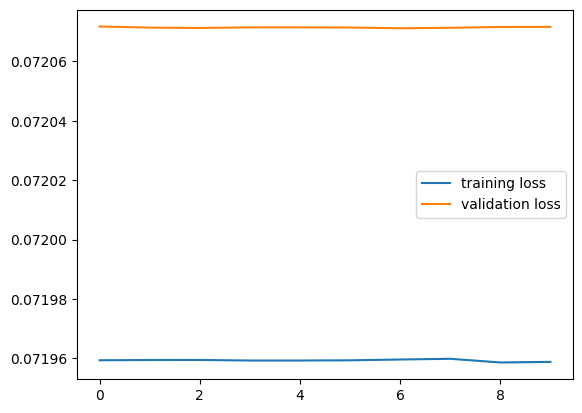

100%|██████████| 10/10 [03:45<00:00, 22.55s/it]


In [19]:
losses = {"train": [], "val": []}
for epoch in tqdm(range(10)):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)

    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

# Visualising Results

It may also be useful to visualize some qualitative examples of classification

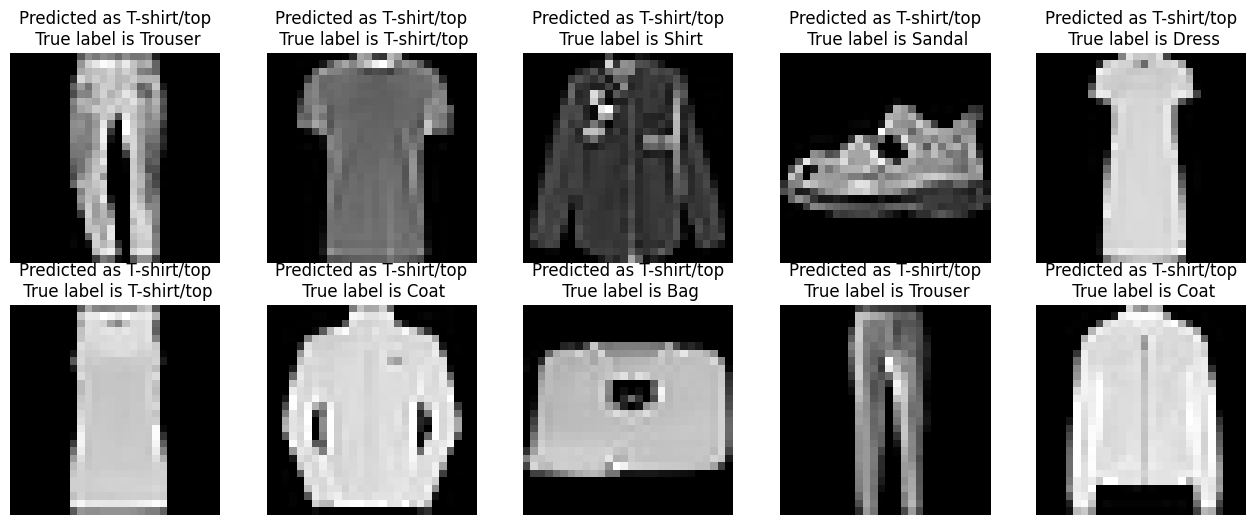

In [23]:
with torch.no_grad():

    data, target = next(iter(val_loader))
    data, target = data.to(device), target.to(device)

    data = data.view(-1, 28*28)
    output = model(data)
    predictions = np.argmax(output.cpu().numpy(), axis=1).tolist()
    true = target.cpu().numpy().tolist()

    plt.figure(figsize=(16, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        image = data[i,...].cpu().numpy().reshape((28,28))
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.title('Predicted as {}\n True label is {}'.format(val_set.classes[predictions[i]], val_set.classes[true[i]], ))

# Homework

<font color="blue">**Exercise 5**: Change the initialization of the model parameters (this will help a great deal) and train your model on the Fashion-MNIST dataset.</font>

In [24]:
def initialize_parameters(model):
    for name, w in model.named_parameters():
        if "weight" in name:
            nn.init.kaiming_uniform_(w, nonlinearity='relu')

        if "bias" in name:
            nn.init.zeros_(w)


learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = FCModel(input_size, 128, output_size)

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2)

initialize_parameters(model)

In [25]:
# evaluate the trained model on the validation set
_ = validate(criterion, model, val_loader)


Test set: Average loss: 0.0401, Accuracy: 1479/10000 (15%)



<font color="blue">**Exercise 6**: Try to improve the Accuracy of your model on the validation set by adding more layers and/or more hidden units in you model. For example you can use a MLP with 2 hidden layers with 512 and 256 units respectively. You can also consider changing the batch size and learning rate if needed.</font>

In [26]:
class FashionMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        return self.model(x)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True, num_workers=1)

learning_rate = 0.1
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility


model = FashionMNIST()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8, weight_decay=lambda_l2) # built-in L2
initialize_parameters(model)

In [46]:
def train(dataloader, model, loss_fn, optimizer, epoch):
    """Train the model on a single pass of the dataloader.

    Args:
        dataloader: an instance of `torch.utils.data.DataLoader`, containing the training data.
        model: an instance of `torch.nn.Module`, the model to be trained.
        loss_fn: a callable, the loss function.
        optimizer: an instance of `torch.optim.Optimizer`, the optimizer used for training.
        epoch: an integer, the current epoch number.
    """
    model.train()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X, y = X.to(device), y.to(device)

        X = X.view(X.size(0), -1)

        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()

        # Calculate accuracy without torchmetrics
        predicted = torch.argmax(pred, dim=1)
        total_correct += (predicted == y).sum().item()
        total_samples += y.size(0)

        # Backpropagation.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss_item = total_loss / 64
    accuracy = total_correct / total_samples if total_samples > 0 else 0
    print("train loss", loss_item)
    print("train accuracy", accuracy)

    return loss_item


In [29]:
for epoch in range(10):
    train(train_loader, model, criterion, optimizer, epoch)


100%|██████████| 938/938 [00:17<00:00, 54.94it/s]

train loss 7.36728756618686
train accuracy 0.8191



100%|██████████| 938/938 [00:16<00:00, 56.59it/s]

train loss 6.7933145822025836
train accuracy 0.8348333333333333



100%|██████████| 938/938 [00:16<00:00, 57.14it/s]

train loss 6.375840028049424
train accuracy 0.8448833333333333



100%|██████████| 938/938 [00:16<00:00, 56.62it/s]

train loss 6.083568066824228
train accuracy 0.8510166666666666



100%|██████████| 938/938 [00:16<00:00, 58.11it/s]

train loss 5.924377039074898
train accuracy 0.85455



100%|██████████| 938/938 [00:18<00:00, 51.37it/s]

train loss 5.743835285771638
train accuracy 0.85845



100%|██████████| 938/938 [00:16<00:00, 58.20it/s]

train loss 5.667574241291732
train accuracy 0.86055



100%|██████████| 938/938 [00:16<00:00, 58.23it/s]

train loss 5.511565254768357
train accuracy 0.8640666666666666



100%|██████████| 938/938 [00:16<00:00, 56.52it/s]

train loss 5.403980180621147
train accuracy 0.8678666666666667



100%|██████████| 938/938 [00:15<00:00, 59.95it/s]

train loss 5.330106709501706
train accuracy 0.871


In [30]:
# evaluate the trained model on the validation set
_ = validate(criterion, model, val_loader)


Test set: Average loss: 0.0058, Accuracy: 8657/10000 (87%)



<font color="blue">**Exercise 7**: Try at least two different [optimizers](https://pytorch.org/docs/stable/optim.html#algorithms) (e.g. SGD with momentum, RMSProp, Adam, etc.) and plot **in a single matplotlib figure** the loss curves for training the model with them. We want them in a single figure to be able to easily compare the three learning curves.</font>

In [50]:
losses = {'RMSPROP': None, 'SGD_Momentum': None, 'ADAM': None}
torch.manual_seed(42)

model = FashionMNIST()
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2)
initialize_parameters(model)

_losses = {"train": [], "val": []}
for epoch in range(6):
    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss = validate(criterion, model, val_loader)
    _losses["train"].append(train_loss)
    _losses["val"].append(val_loss)

losses['SGD_Momentum'] = (_losses['train'], _losses['val'])

model = FashionMNIST()
model.to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
initialize_parameters(model)

# training loop
_losses = {"train": [], "val": []}
for epoch in range(6):
    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss = validate(criterion, model, val_loader)
    _losses["train"].append(train_loss)
    _losses["val"].append(val_loss)

losses['RMSPROP'] = (_losses['train'], _losses['val'])

model = FashionMNIST()
model.to(device)

# Adam with default parameters
optimizer = optim.Adam(model.parameters())
initialize_parameters(model)

# training loop
_losses = {"train": [], "val": []}
for epoch in range(6):
    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss = validate(criterion, model, val_loader)
    _losses["train"].append(train_loss)
    _losses["val"].append(val_loss)

losses['ADAM'] = (_losses['train'], _losses['val'])

100%|██████████| 938/938 [00:16<00:00, 58.32it/s]

train loss 11.468376182485372
train accuracy 0.7098333333333333



Test set: Average loss: 0.0089, Accuracy: 7966/10000 (80%)



100%|██████████| 938/938 [00:16<00:00, 56.94it/s]

train loss 9.686267987359315
train accuracy 0.76095



Test set: Average loss: 0.0089, Accuracy: 7967/10000 (80%)



100%|██████████| 938/938 [00:16<00:00, 57.45it/s]

train loss 9.001366090029478
train accuracy 0.7791166666666667



Test set: Average loss: 0.0082, Accuracy: 8192/10000 (82%)



100%|██████████| 938/938 [00:16<00:00, 55.19it/s]

train loss 8.540627007139847
train accuracy 0.7958833333333334



Test set: Average loss: 0.0077, Accuracy: 8289/10000 (83%)



100%|██████████| 938/938 [00:16<00:00, 58.38it/s]

train loss 8.456351637840271
train accuracy 0.7981666666666667



Test set: Average loss: 0.0083, Accuracy: 8154/10000 (82%)



100%|██████████| 938/938 [00:16<00:00, 55.26it/s]

train loss 8.423546352889389
train accuracy 0.7993



Test set: Average loss: 0.0084, Accuracy: 8119/10000 (81%)



100%|██████████| 938/938 [00:16<00:00, 57.59it/s]

train loss 40827.38362017274
train accuracy 0.10653333333333333



Test set: Average loss: 0.0364, Accuracy: 1000/10000 (10%)



100%|██████████| 938/938 [00:16<00:00, 57.52it/s]

train loss 38.979736026376486
train accuracy 0.09931666666666666



Test set: Average loss: 0.0363, Accuracy: 1000/10000 (10%)



100%|██████████| 938/938 [00:15<00:00, 58.67it/s]

train loss 39.62454966455698
train accuracy 0.09898333333333334



Test set: Average loss: 0.0367, Accuracy: 1000/10000 (10%)



100%|██████████| 938/938 [00:16<00:00, 58.08it/s]

train loss 43.337177101522684
train accuracy 0.10103333333333334



Test set: Average loss: 0.0365, Accuracy: 1000/10000 (10%)



100%|██████████| 938/938 [00:16<00:00, 58.21it/s]

train loss 41.06415135785937
train accuracy 0.09971666666666666



Test set: Average loss: 0.0364, Accuracy: 1000/10000 (10%)



100%|██████████| 938/938 [00:15<00:00, 58.73it/s]

train loss 34.064887031912804
train accuracy 0.09803333333333333



Test set: Average loss: 0.0363, Accuracy: 1000/10000 (10%)



100%|██████████| 938/938 [00:16<00:00, 57.12it/s]

train loss 8.915574840269983
train accuracy 0.7832333333333333



Test set: Average loss: 0.0068, Accuracy: 8439/10000 (84%)



100%|██████████| 938/938 [00:15<00:00, 58.87it/s]

train loss 6.2926377698313445
train accuracy 0.8459666666666666



Test set: Average loss: 0.0063, Accuracy: 8564/10000 (86%)



100%|██████████| 938/938 [00:16<00:00, 56.57it/s]

train loss 5.698103417875245
train accuracy 0.8592166666666666



Test set: Average loss: 0.0059, Accuracy: 8638/10000 (86%)



100%|██████████| 938/938 [00:15<00:00, 58.84it/s]

train loss 5.418031515786424
train accuracy 0.8659333333333333



Test set: Average loss: 0.0058, Accuracy: 8653/10000 (87%)



100%|██████████| 938/938 [00:16<00:00, 56.18it/s]

train loss 5.121925910119899
train accuracy 0.8735666666666667



Test set: Average loss: 0.0061, Accuracy: 8584/10000 (86%)



100%|██████████| 938/938 [00:15<00:00, 58.87it/s]

train loss 4.960875843768008
train accuracy 0.8768



Test set: Average loss: 0.0055, Accuracy: 8723/10000 (87%)



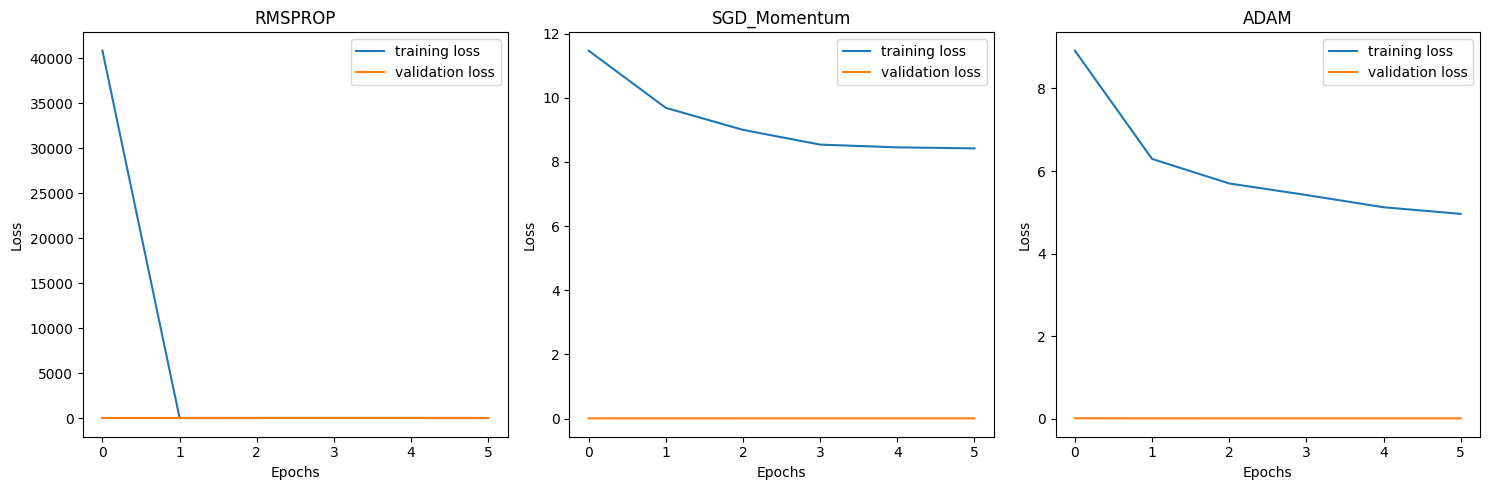

In [51]:
optimizers = list(losses.keys())
num_optimizers = len(optimizers)

fig, axes = plt.subplots(1, num_optimizers, figsize=(15, 5))

if num_optimizers == 1:
    axes = [axes]

for i, optimizer in enumerate(optimizers):
    train_losses, val_losses = losses[optimizer]
    axes[i].set_title(optimizer)
    axes[i].plot(train_losses, label='training loss')
    axes[i].plot(val_losses, label='validation loss')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')
    axes[i].legend()

plt.tight_layout()
plt.show()

There is some wrong with the RMSProp on this run.

<font color="blue">**Exercise 8**: Calculate the Accuracy for each individual class in the dataset and plot the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix) of your trained models.</font>

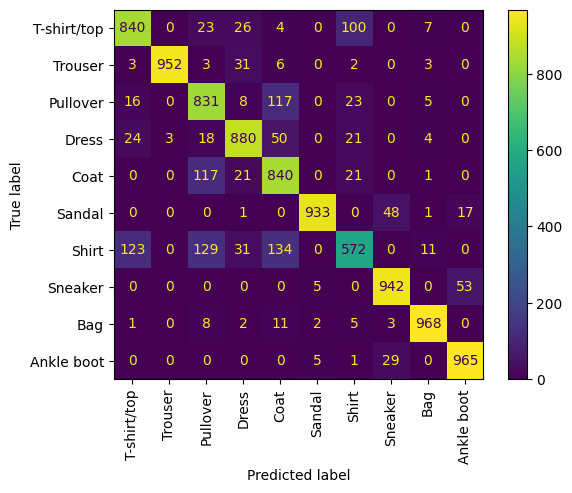

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

@torch.no_grad()  # prevent this function from computing gradients
def evaluate(model, loader):

    predictions = []
    true = []

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)
        output = model(data)
        predictions += np.argmax(output.cpu().numpy(), axis=1).tolist()
        true += target.cpu().numpy().tolist()

    return true, predictions

true, pred = evaluate(model, val_loader)
cm = confusion_matrix(true, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_set.classes)
disp.plot(xticks_rotation='vertical')


Shirts and T-shirts are similar, yes.

## I reality I already did all of this



Was just trying MLFLOW, with it, it would be sooo much easier to get the plots.

Here is the whole script that i did:

In [ ]:
import sys
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import mlflow

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

print(f"Image size: {training_data[0][0].shape}")
print(f"Size of training dataset: {len(training_data)}")
print(f"Size of test dataset: {len(test_data)}")

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        return self.model(x)


mlflow.set_tracking_uri("http://atenea:5000")

# Get cpu or gpu for training.
device = "cuda" if torch.cuda.is_available() else "cpu"


def train(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X, y = X.to(device), y.to(device)

        X = X.view(X.size(0), -1)

        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()

        # Calculate accuracy without torchmetrics
        predicted = torch.argmax(pred, dim=1)
        total_correct += (predicted == y).sum().item()
        total_samples += y.size(0)

        # Backpropagation.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss_item = total_loss / 64
    accuracy = total_correct / total_samples if total_samples > 0 else 0
    mlflow.log_metric("train loss", loss_item, step=epoch)
    mlflow.log_metric("train accuracy", accuracy, step=epoch)


def evaluate(dataloader, model, loss_fn, epoch):
    num_batches = len(dataloader)
    model.eval()
    eval_loss, eval_correct, eval_samples = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.view(X.size(0), -1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            eval_loss += loss_fn(pred, y).item()
            predicted = torch.argmax(pred, dim=1)
            eval_correct += (predicted == y).sum().item()
            eval_samples += y.size(0)

    eval_loss /= num_batches
    eval_accuracy = eval_correct / eval_samples if eval_samples > 0 else 0

    mlflow.log_metric("eval_loss", eval_loss, step=epoch)
    mlflow.log_metric("eval_accuracy", eval_accuracy, step=epoch)

    print(f"Eval metrics: Accuracy: {eval_accuracy:.2f}, Avg loss: {eval_loss:2f} ")


mlflow.set_experiment("test-pytorch-mnist-fashion")

epochs = 10
loss_fn = nn.CrossEntropyLoss()
model = ImageClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_iter = iter(train_dataloader)
example_batch = next(train_iter)
input_example = example_batch[0][0].unsqueeze(0).to(device)
input_example = input_example.view(input_example.size(0), -1)

with mlflow.start_run() as run:
    hyper_params = {
        "epochs": epochs,
        "learning_rate": 1e-3,
        "batch_size": 64,
        "loss_function": loss_fn.__class__.__name__,
        "optimizer": "Adam",
        "dataset": "FashionMNIST",
    }
    # Log training parameters.
    mlflow.log_params(hyper_params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(model))

    mlflow.log_artifact("model_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t + 1}-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer, epoch=t)
        evaluate(test_dataloader, model, loss_fn, epoch=t)

        # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model", input_example=input_example.cpu().numpy())


### Screenshots from the mlslow dashboard

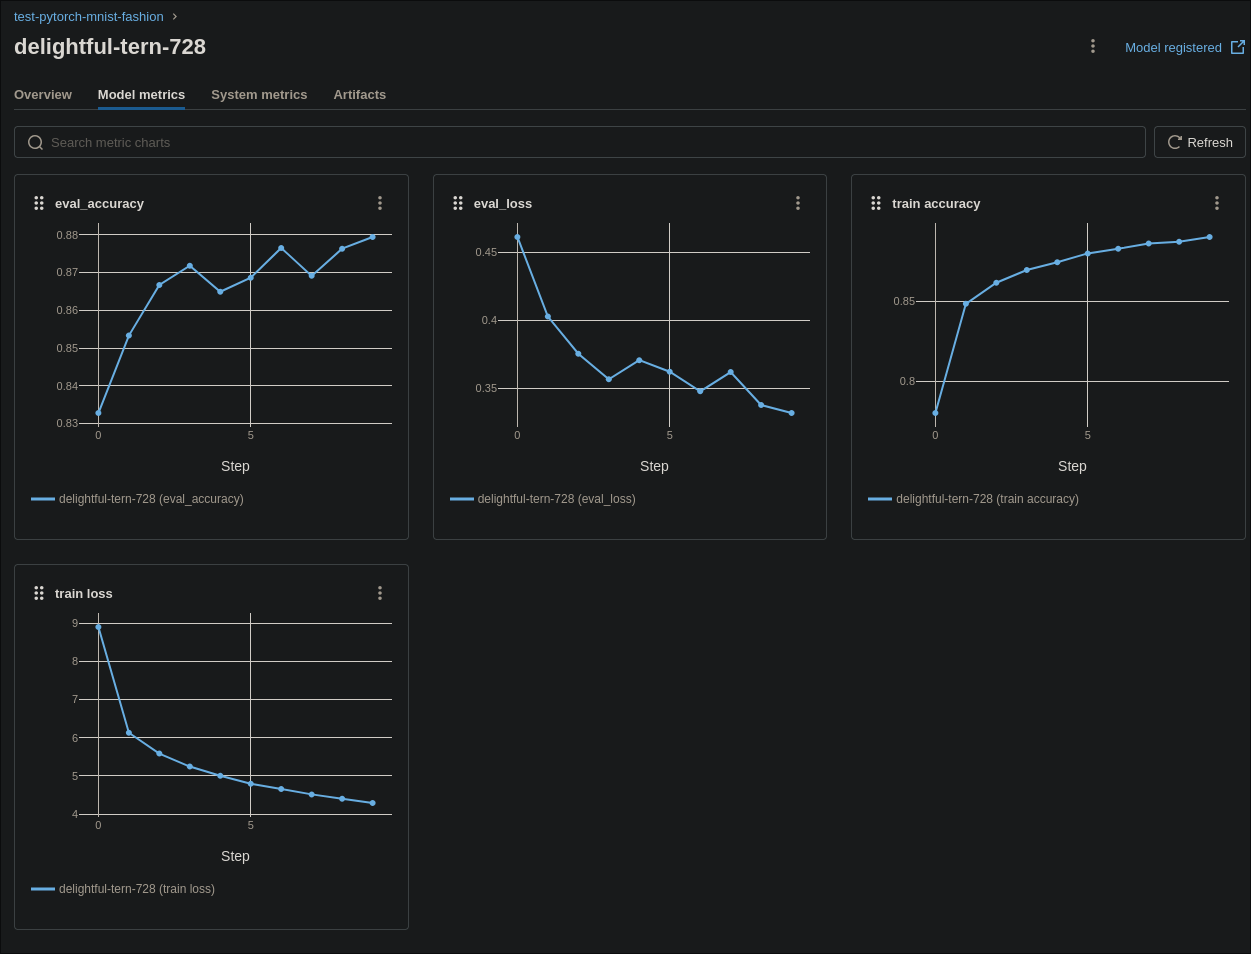


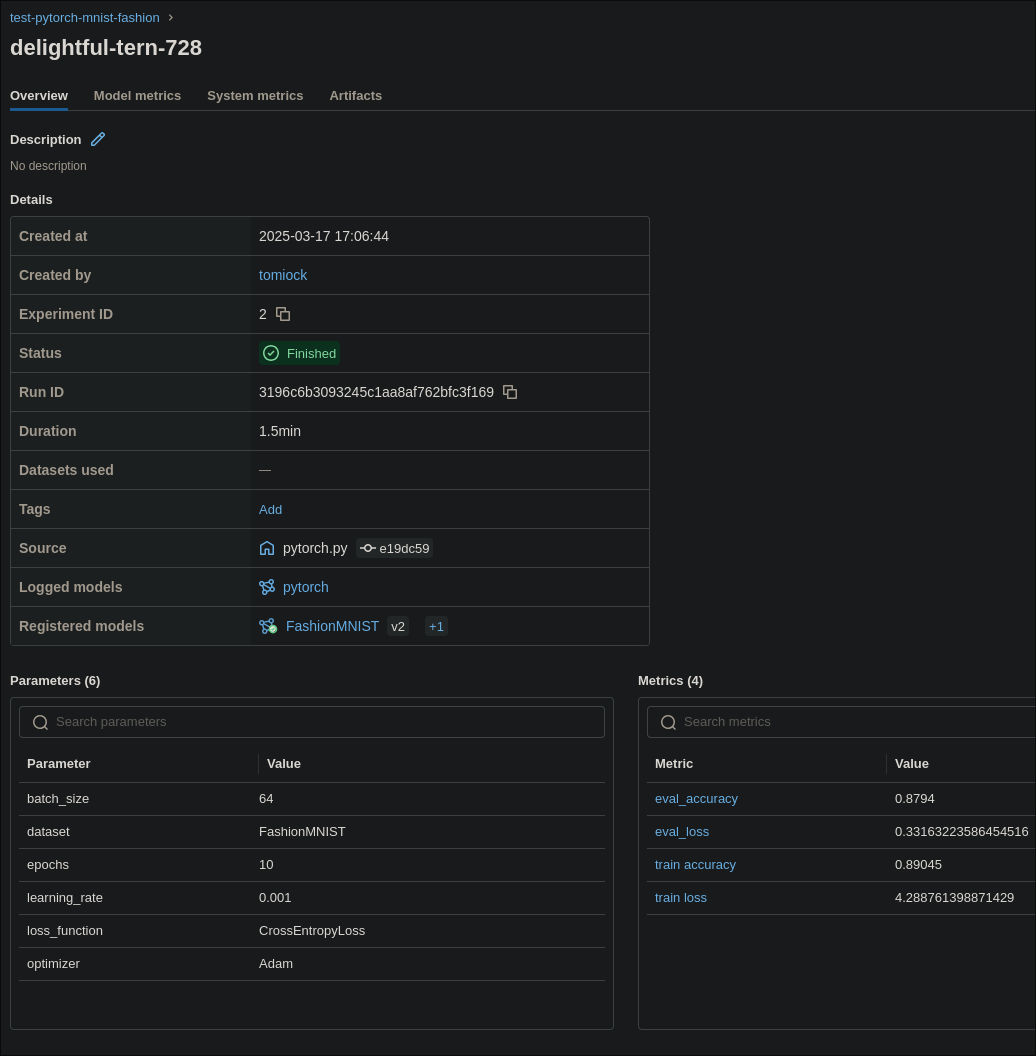